# Задание №5. Численные методы решения задачи Коши для СОДУ

Импорт библиотек:

In [94]:
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt

Параметры:

In [95]:
A=1/30
B=1/15
c2 = 1/20
eps = 10**(-4)
y0 = np.array([B*np.pi,A*np.pi])
x0=0
xk = np.pi

Функция правой части:

In [96]:
def f(x,y):
    return(np.array([A*y[1],-B*y[0]]))

Функция вычисления коэффициентов:

In [97]:
def get_koefs_2(c2):
    a = c2
    b1 = 1-1/(2*c2)
    b2 = 1/(2*c2)
    return a,b1,b2

Функция вычисления начального шага:

In [98]:
def start_step(f,s,x0,xk,y0,eps):
    f=f(x0,y0)
    delta = (1/max(abs(x0),abs(xk)))**(s+1) + (np.linalg.norm(f))**(s+1)
    h = (eps/delta)**(1/(s+1))
    return h

Корректирующие функции:

In [99]:
def k1(h,f,x,y):
    return h*f(x,y)
def k2(h,f,c2,a1,x,y,k_1):
    return h*f(x+c2*h,y+a1*k_1)
def k3(h,f,c2,a1,x,y,k_2):
    return h*f(x+c2*h,y+a1*k_2)
def k4(h,f,c2,a1,x,y,k_3):
    return h*f(x+c2*h,y+a1*k_3)

Вычисление приближенного значения функции с заданным шагом:

In [100]:
def y_step(x,y,f,coefs,h):
    k_1 = k1(h,f,x,y)
    return(y + coefs[1]*k_1 + coefs[2]*k2(h,f,c2,coefs[0],x,y,k_1),2)

Метод с постоянным шагом:

In [101]:
def R_K(x0,xk,y0,h,coefs,step_fun):
    counter = 0
    y=[]
    y.append(y0)
    x = x0
    xlist=[]
    xlist.append(x0)
    while x != xk:
        if abs(xk-x) < h:
            h = (xk-x)
        y_new,m = step_fun(xlist[-1],y[-1],f,coefs,h)
        counter+=m
        y.append(y_new)
        x+=h
        xlist.append(x)
    return y, xlist, counter

Вычисление погрешности по методу Рунге:

In [102]:
def R(y1,y2,s,flag=0):
    if flag==0:
        return np.linalg.norm(y2-y1)/(1-2**(-s))
    else:
        return np.linalg.norm(y2-y1)/(2**s-1)

Функции вычисления истинного значения в точке:

In [103]:
def real_z(x):
    C1 = -1/15*np.pi
    C2 = 1/(30*sqrt(2))*np.pi
    y1 = C2*np.sin(x/(15*sqrt(2))) - C1*np.cos(x/(15*sqrt(2)))
    y2 = sqrt(2)*C1*np.sin(x/(15*sqrt(2))) + sqrt(2)*C2*np.cos(x/(15*sqrt(2)))
    return([y1,y2])

Автоматический выбор шага:

In [104]:
def auto_step(x,y,h,tol,s,coefs,step_fun,num):
    counter = num
    y1,m = step_fun(x,y,f,coefs,h)
    counter+=m
    y2,m = step_fun(x,y,f,coefs,h/2)
    counter+=m
    y2,m = step_fun(x+h/2,y2,f,coefs,h/2)
    counter+=m
    Rq = abs(R(y1,y2,s,flag=0))
    if Rq > 2**s*tol:
        h=h/2
        return(auto_step(x,y,h,tol,s,coefs,step_fun,counter))
    elif tol < Rq <= 2**s*tol:
        return (h/2,y2,Rq,x+h,counter)
    elif tol/(2**(s+1)) < Rq <= tol:
        return(h,y1,Rq,x+h,counter)
    elif Rq <= tol/(2**(s+1)):
        return(2*h, y1, Rq,x+h,counter)

Общая функция для приближенного вычисления решения:

In [198]:
def custom_R_K(x0,xk,y0,eps,tol,step_fun,s,c2=None, mode = 'standart'):
    h = start_step(f,s,x0,xk,y0,tol)
    counter = 0
    if c2 == None:
        coefs=[]
    else:
        coefs = get_koefs_2(c2)
        
    ##Случай авто
    if mode == 'auto':
        Rq = []
        y=[]
        steps=[]
        y.append(y0)
        x = x0
        xlist=[]
        xlist.append(x0)
        while x != xk:
            if abs(xk-x) < h:
                h=xk-x
                y_new,m = step_fun(x,y[-1],f,coefs,h)
                counter+=m
                steps.append(h)
                h=h/2
                y2,m = step_fun(x,y[-1],f,coefs,h)
                counter+=m
                y2,m = step_fun(x,y2,f,coefs,h)
                counter+=m
                Rq.append(abs(R(y_new,y2,s,flag=0)))
                y.append(y_new)
                x=xk
                xlist.append(x)
            else:
                steps.append(h)
                h,y1,r,x,m = auto_step(x,y[-1],h,eps,s,coefs,step_fun,0)
                counter+=m
                xlist.append(x)
                Rq.append(r)
                y.append(y1)
        return y, xlist, steps,Rq, counter
    
    ##случай постоянного шага
    else:
        y1,x1,m = R_K(x0,xk,y0,h,coefs,step_fun)
        counter+=m
        while True:
            y2,x2,m = R_K(x0,xk,y0,h/2,coefs,step_fun)
            counter+=m
            R1 = abs(R(y1[-1],y2[-1],s,flag=0))
            R2 = abs(R(y1[-1],y2[-1],s,flag=1))
            if R1 < eps:
                ansy = y1
                ansx = x1
                step = h
                Rq = R1
                break
            if R2 < eps:
                ansy = y2
                ansx = x2
                step = h/2
                Rq = R2
                break
            h = h/2
            y1,x1=y2,x2
        return ansy,ansx,step, Rq,counter

In [194]:
eps = 10**(-4)
y,x,step,Rq,count=custom_R_K(x0,xk,y0,eps,eps,y_step,2,c2)
print('Полученное решение:', y[-1])
print('Количество обращений к правой части: ',count)
print('Шаг: ',step)

Полученное решение: [0.21807575 0.05985268]
Количество обращений к правой части:  22
Шаг:  1


График зависимости истинной полной погрешности от значения независимой переменной:

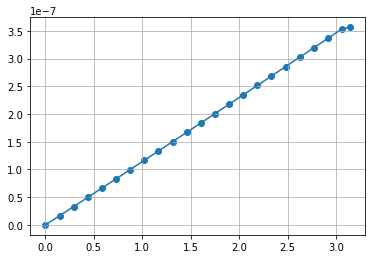

In [107]:
x = np.array(x)
z = real_z(x)
y = np.array(y)
z1 = np.reshape(z[0],(len(y),1))
z2 = np.reshape(z[1],(len(y),1))
z = np.concatenate((z1,z2),axis=1)
plt.plot(x,np.linalg.norm(z-y,axis=1))
plt.scatter(x,np.linalg.norm(z-y,axis=1))
plt.grid()

Отличие от аналитического:

In [108]:
z=real_z(np.pi)

In [109]:
z[0]-y[-1][0],z[1]-y[-1][1]

(-4.9775494614934246e-08, 3.529162080281867e-07)

In [110]:
eps = 10**(-5)
y,x,step,Rq,count=custom_R_K(x0,xk,y0,eps,eps/10,y_step,2,c2,mode = 'auto')
print('Полученное решение:', y[-1])
print('Количество обращений к правой части: ',count)
print('Шаги: ',step)

Полученное решение: [0.21807502 0.05985707]
Количество обращений к правой части:  48
Шаги:  [0.03141495859922239, 0.06282991719844477, 0.12565983439688955, 0.2513196687937791, 0.5026393375875582, 1.0052786751751164, 1.0052786751751164, 0.15717158666366648]


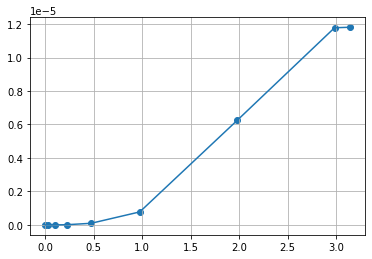

In [111]:
x = np.array(x)
z = real_z(x)
y = np.array(y)
z1 = np.reshape(z[0],(len(y),1))
z2 = np.reshape(z[1],(len(y),1))
z = np.concatenate((z1,z2),axis=1)
plt.plot(x,np.linalg.norm(z-y,axis=1))
plt.scatter(x,np.linalg.norm(z-y,axis=1))
plt.grid()

Отличие от аналитического:

In [112]:
z=real_z(np.pi)

In [113]:
z[0]-y[-1][0],z[1]-y[-1][1]

(-1.8949279856350643e-06, 1.1657368108437816e-05)

# Классический метод Рунге-Кутты

Используем классический метод Рунге-Кутты

In [114]:
def y_step_cls(x,y,f,coefs,h):
    k_1 = k1(h,f,x,y)
    k_2 = k2(h,f,1/2,1/2,x,y,k_1)
    k_3 = k3(h,f,1/2,1/2,x,y,k_2)
    return (y+1/6*(k_1+2*k_2+2*k_3+k4(h,f,1,1,x,y,k_3)),4)

Метод с постоянным шагом

In [115]:
eps = 10**(-4)
y,x,step,Rq,count=custom_R_K(x0,xk,y0,eps,eps,y_step_cls,4)
print('Полученное решение:', y[-1])
print('Количество обращений к правой части: ',count)
print('Шаг: ',step)

Полученное решение: [0.21807313 0.05986873]
Количество обращений к правой части:  80
Шаг:  0.49790886219738784


Отличие от аналитического:

In [116]:
z[0]-y[-1][0],z[1]-y[-1][1]

(1.660260817715198e-11, -1.0946458323113362e-10)

Метод с автоматическим выбором шага

In [120]:
eps = 10**(-5)
y,x,Rq,steps,count=custom_R_K(x0,xk,y0,eps,eps*10,y_step_cls,4,mode = 'auto')
print('Полученное решение:', y[-1])
print('Количество обращений к правой части: ',count)
print('Шаг: ',step)

Полученное решение: [0.21807313 0.05986874]
Количество обращений к правой части:  36
Шаг:  0.49790886219738784


Отличие от аналитического:

In [121]:
z[0]-y[-1][0],z[1]-y[-1][1]

(1.4275756132775541e-09, -7.761914389003977e-09)

## Вычисление графиков зависимости величины шага интегрирования от значения независимой переменной 𝑥:

2-ух этапный метод:

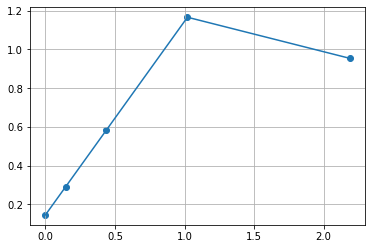

In [199]:
eps = 10**(-5)
y2,x2,steps2,Rq2,count2=custom_R_K(x0,xk,y0,eps,eps*10,y_step,2,c2,mode = 'auto')
plt.plot(x2[0:-1],steps2)
plt.scatter(x2[0:-1],steps2)
plt.grid()

4-ех этапный метод:

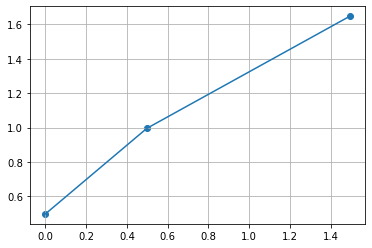

In [200]:
eps = 10**(-5)
y1,x1,steps1,Rq1,count1=custom_R_K(x0,xk,y0,eps,eps*10,y_step_cls,4,mode = 'auto')
plt.plot(x1[0:-1],steps1)
plt.scatter(x1[0:-1],steps1)
plt.grid()

## Графики зависимости отношения истинной локальной погрешности к полученной оценке локальной погрешности от значения независимой переменной 𝑥:

Подсчет решения задачи Коши в заданной точке и с заданными начальными значениями

In [201]:
def real_y(x,x0,y):
    if x0<10**(-5):
        C1 = -1/15*np.pi
        C2 = 1/(30*sqrt(2))*np.pi
    else :
        C1 = (y[1]-sqrt(2)*y[0]*(np.tan(x0/(15*sqrt(2)))**(-1)))/(sqrt(2)*(np.sin(x0/(15*sqrt(2)))+np.cos(x0/(15*sqrt(2)))*np.tan(x0/(15*sqrt(2)))**(-1)))
        C2 = (y[0]+C1*np.cos(x0/(15*sqrt(2))))/np.sin(x0/(15*sqrt(2)))
        print(C1,C2)
    y1 = C2*np.sin(x/(15*sqrt(2))) - C1*np.cos(x/(15*sqrt(2)))
    y2 = sqrt(2)*C1*np.sin(x/(15*sqrt(2))) + sqrt(2)*C2*np.cos(x/(15*sqrt(2)))
    return([y1,y2])

Локальные погрешности в двухэтапном методе

In [202]:
def true_yx(xk,yk):
    true_y=[yk[0]]
    for i in range(1,len(xk)):
        true_y.append(real_y(xk[i],xk[i-1],yk[i-1]))
    return true_y

In [203]:
Rq2.insert(0,1)

In [204]:
zy2 = z2-y2
zy2[zy2==0] = 1/sqrt(2)
np.linalg.norm(zy2,axis=1)/Rq2

array([1.        , 1.00014119, 1.00027332, 1.00051025, 1.00087373,
       1.00058246])

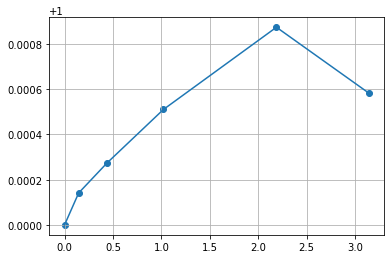

In [205]:
plt.plot(x2,np.linalg.norm(zy2,axis=1)/Rq2)
plt.scatter(x2,np.linalg.norm(zy2,axis=1)/Rq2)
plt.grid()

In [206]:
Rq1.insert(0,1)

In [207]:
z1 =np.array(true_yx(x1,y1))

-0.2094395102346813 0.0740480489816512
-0.209439510078562 0.07404804937371116


In [208]:
zy1 = z1-y1
zy1[zy1==0] = 1/sqrt(2)
np.linalg.norm(zy1,axis=1)/Rq1

array([1.        , 1.00010314, 1.00018573, 1.00024027])

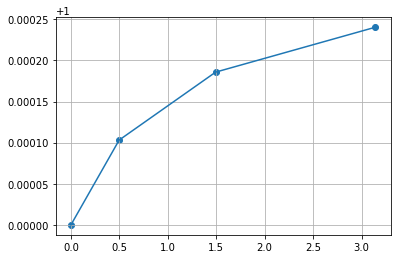

In [209]:
plt.plot(x1,np.linalg.norm(zy1,axis=1)/Rq1)
plt.scatter(x1,np.linalg.norm(zy1,axis=1)/Rq1)
plt.grid()

Графики зависимости количества вычислений правой части системы от заданной точности 𝜀:

In [210]:
epses = [10**(-i) for i in range(2,6)]

Text(0, 0.5, 'количество вычислений')

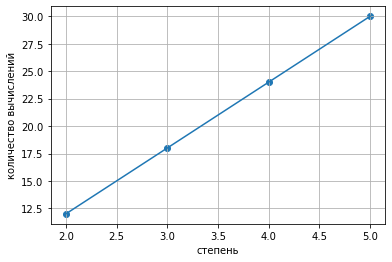

In [211]:
counts=[]
for eps in epses:
    y2,x2,steps2,Rq2,count2=custom_R_K(x0,xk,y0,eps,eps*10,y_step,2,c2,mode = 'auto')
    counts.append(count2)
plt.plot([i for i in range(2,6)],counts)
plt.grid()
plt.scatter([i for i in range(2,6)],counts)
plt.xlabel('степень')
plt.ylabel('количество вычислений')

Text(0, 0.5, 'количество вычислений')

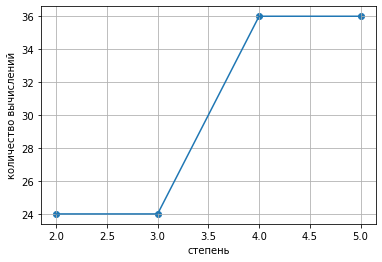

In [212]:
counts=[]
for eps in epses:
    y1,x1,steps1,Rq1,count1=custom_R_K(x0,xk,y0,eps,eps*10,y_step_cls,4,mode = 'auto')
    counts.append(count1)
plt.plot([i for i in range(2,6)],counts)
plt.grid()
plt.scatter([i for i in range(2,6)],counts)
plt.xlabel('степень')
plt.ylabel('количество вычислений')